## Softmax Function
- https://www.jianshu.com/p/cb93d5e39bca

In [1]:
import numpy as np
def softmax_function(x):
    return np.exp(x) / np.sum(np.exp(x))


y = np.array([0.8,0.5,0.7,0.6,0.9,1.5])

softmax_function(y)


array([0.15189927, 0.11252975, 0.13744415, 0.12436461, 0.16787466,
       0.30588757])

In [6]:
import numpy as np
def softmax_function_with_temperature(x, temperature):
    return np.exp(x/temperature) / np.sum(np.exp(x/temperature))
# temperature 大：各機率接近，各機率都可能超過 threshold，被激活的隨機性較高
softmax_function_with_temperature(y,10)

array([0.16602326, 0.16111653, 0.1643713 , 0.16273578, 0.16769182,
       0.17806131])

In [7]:
softmax_function_with_temperature(y,0.5)

array([0.12027232, 0.06600685, 0.09847065, 0.08062095, 0.14690094,
       0.4877283 ])

## Time Series Analysis in Python
- https://www.kaggle.com/rakannimer/air-passenger-prediction
- https://github.com/ywchiu/cdc_course/blob/master/slides/20180724%20-%20R%20%E8%AA%9E%E8%A8%80%E8%88%87%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92(%E4%B8%83).pdf

## Normal Distribution

Populating the interactive namespace from numpy and matplotlib


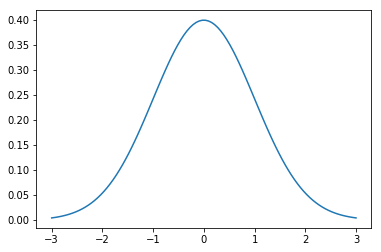

In [14]:
% pylab inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import math

mu       = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.show()

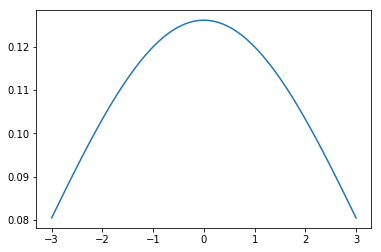

In [17]:
mu       = 0
variance = 10
sigma = math.sqrt(variance)
# x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x = np.linspace(mu - 3, mu + 3, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.show()

## 使用VAE 生成圖片

### 引用套件

In [18]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

from   scipy.stats import norm
import matplotlib.image as matimg
import glob

from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives

D:\Anaconda3\envs\myenv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 設定網路參數

In [39]:
num_training_examples = 1200
num_testing_examples  = 125

batch_size   = 25
original_dim = 64 * 64 * 3 #this is same as image_vector_size
latent_dim   = 2
intermediate_dim = 256
epsilon_std  = 1.0

### 讀取圖片

In [22]:
def load_image(path):
    img = matimg.imread(path)
    return img

#following code loads data from local repo
#directory should have two subfolders, with name train and test
def load_local_data(path):
    paths = glob.glob(os.path.join(path + "/train", "*.jpg"))
    X_train = np.array( [ load_image(p) for p in paths ] )

    paths = glob.glob(os.path.join(path + "/test", "*.jpg"))
    X_test = np.array( [ load_image(p) for p in paths ] )
   
    return X_train, X_test

### 建立 Encoder

In [23]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean    = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [25]:
type(z_mean)

tensorflow.python.framework.ops.Tensor

### 取樣函數

In [3]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

### 建立解碼器

In [28]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h    = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded    = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

### 計算 VAE 損失

#### KL Divergence
- https://zh.wikipedia.org/wiki/%E7%9B%B8%E5%AF%B9%E7%86%B5

In [29]:
# modified calculation of loss
def vae_loss(x, x_decoded_mean):
    # xent_loss is reconstruction error
    # use binary_crossentropy because this is not multi-label classification or regression but unsupervised problem
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

### 建立 VAE 模型

In [32]:
# vae model
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

# if want to train with data from local repo
path="../newyorkB"
(x_train, x_test) = load_local_data(path)

x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32')  / 255.

In [33]:
x_train.shape

(1200, 64, 64, 3)

In [34]:
x_test.shape

(125, 64, 64, 3)

In [40]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test  = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [41]:
x_train.shape

(1200, 12288)

In [42]:
x_test.shape

(125, 12288)

In [43]:
#to train the model
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=50,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 1200 samples, validate on 125 samples
Epoch 1/50
  25/1200 [..............................] - ETA: 6s - loss: 6405.5488

D:\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


1200/1200 [==============================] - 6s 5ms/step - loss: 6436.9128 - val_loss: 6566.7254
Epoch 2/50
1200/1200 [==============================] - 6s 5ms/step - loss: 6412.5558 - val_loss: 6474.8813
Epoch 3/50
1200/1200 [==============================] - 7s 6ms/step - loss: 6341.4650 - val_loss: 6457.8501
Epoch 4/50
1200/1200 [==============================] - 6s 5ms/step - loss: 6328.1218 - val_loss: 6432.7105
Epoch 5/50
1200/1200 [==============================] - 6s 5ms/step - loss: 6308.0475 - val_loss: 6429.2404
Epoch 6/50
1200/1200 [==============================] - 7s 5ms/step - loss: 6293.4338 - val_loss: 6431.1146
Epoch 7/50
1200/1200 [==============================] - 6s 5ms/step - loss: 6278.5354 - val_loss: 6475.8488
Epoch 8/50
1200/1200 [==============================] - 7s 6ms/step - loss: 6268.0971 - val_loss: 6404.5690
Epoch 9/50
1200/1200 [==============================] - 6s 5ms/step - loss: 6265.1621 - val_loss: 6405.7722
Epoch 10/50
1200/1200 [================

### HDF5
- https://support.hdfgroup.org/HDF5/

In [44]:
vae.save_weights('vae_landscape_weights.h5')

In [45]:
vae.load_weights('vae_landscape_weights.h5')

### 產生生成器

In [ ]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

# build a generator(decoder) that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded      = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

### 圖片生成

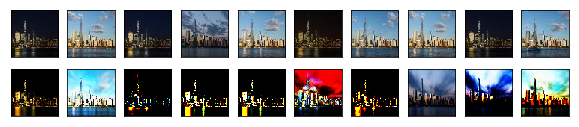

In [52]:
img_size = 64

# following values can generate some good skyline images
samples_encoded = [[5.55, -3.33], [-1.11, 10], [120, 13.3], [33.33, -77.77], [11.11, -33.33], [11.11, 11.11], [100, -33.33], [-7.77, -1.11], [-33.33, -11.11], [-33.33, 11.11]]
samples         = x_test[15:25]


# code to create a result.png with generated images
plt.figure(figsize=(10, 2))

for i, yi in enumerate(samples_encoded):
    z_sample = np.array([[yi[0], yi[1]]])
    x_decoded = generator.predict(z_sample)
    # x_decoded.shape is (1, img_size * img_size * 3)
    picture = x_decoded[0].reshape(img_size, img_size, 3)
    ax = plt.subplot(2, 10, i + 10 + 1)
    plt.imshow(picture)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax1 = plt.subplot(2, 10, i + 1)
    plt.imshow(samples[i].reshape(img_size, img_size, 3))
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

plt.savefig('result.png')
plt.show()

## CelebA
- http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

## GAN

- ! pip uninstall keras
- ! pip install keras==2.1.2


In [28]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import os

In [29]:
# set up network parameters
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 10
batch_size = 16
epsilon_std = 1.0

In [30]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [31]:
def build_encoder():
    img = Input(shape=img_shape)
    h = Flatten()(img)
    h = Dense(512)(h)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dense(512)(h)
    h = LeakyReLU(alpha=0.2)(h)
    mu = Dense(latent_dim)(h)
    log_var = Dense(latent_dim)(h)
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([mu, log_var])
    return Model(img, z)

In [36]:
def build_decoder():
    model = Sequential()
    model.add(Dense(512, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    # tanh is more robust: gradient not equal to 0 around 0
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    model.summary()
    z = Input(shape=(latent_dim,))
    img = model(z)
    return Model(z, img)

In [37]:
def build_discriminator():
    model = Sequential()
    model.add(Dense(512, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.summary()
    encoded_repr = Input(shape=(latent_dim,))
    validity = model(encoded_repr)
    return Model(encoded_repr, validity)

In [45]:
def train(epochs, batch_size=128, sample_interval=50):
    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        #  Train Discriminator

        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        latent_fake = encoder.predict(imgs)
        latent_real = np.random.normal(size=(batch_size, latent_dim))

        # Train the discriminator
        # let latent_real's output is close to 1
        d_loss_real = discriminator.train_on_batch(latent_real, valid)
        # let latent_fake's output is close to 0
        d_loss_fake = discriminator.train_on_batch(latent_fake, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        # decrease reconstruction error and let discriminator's output is close to 1
        g_loss = adversarial_autoencoder.train_on_batch(imgs, [imgs, valid])

        # Plot the progress
        print("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (
            epoch, d_loss[0], 100 * d_loss[1], g_loss[0], g_loss[1]))

        # Plot the progress
        print("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (
            epoch, d_loss[0], 100 * d_loss[1], g_loss[0], g_loss[1]))

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            sample_images(epoch)

In [46]:
def sample_images(epoch):
    r, c = 5, 5
    z = np.random.normal(size=(r * c, latent_dim))
    gen_imgs = decoder.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

In [47]:
optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

# Build the encoder / decoder
encoder = build_encoder()
decoder = build_decoder()

img = Input(shape=img_shape)
# The generator takes the image, encodes it and reconstructs it
# from the encoding
encoded_repr = encoder(img)
reconstructed_img = decoder(encoded_repr)

# For the adversarial_autoencoder model we will only train the generator
# if discriminator is attached to generator, set this flag to fix discriminator
discriminator.trainable = False

# The discriminator determines validity of the encoding
validity = discriminator(encoded_repr)

# The adversarial_autoencoder model  (stacked generator and discriminator)
adversarial_autoencoder = Model(img, [reconstructed_img, validity])
adversarial_autoencoder.compile(loss=['mse', 'binary_crossentropy'], loss_weights=[0.999, 0.001], optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 512)               5632      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 257       
Total params: 137,217
Trainable params: 137,217
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

In [48]:
import os
os.makedirs('images', exist_ok=True)

In [49]:
train(epochs=2000, batch_size=batch_size, sample_interval=200)

D:\Anaconda3\envs\myenv\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.708482, acc: 40.62%] [G loss: 0.106759, mse: 0.106135]
0 [D loss: 0.708482, acc: 40.62%] [G loss: 0.106759, mse: 0.106135]
1 [D loss: 0.693906, acc: 46.88%] [G loss: 0.101585, mse: 0.100938]
1 [D loss: 0.693906, acc: 46.88%] [G loss: 0.101585, mse: 0.100938]
2 [D loss: 0.704077, acc: 37.50%] [G loss: 0.119226, mse: 0.118604]
2 [D loss: 0.704077, acc: 37.50%] [G loss: 0.119226, mse: 0.118604]
3 [D loss: 0.720556, acc: 37.50%] [G loss: 0.113237, mse: 0.112590]
3 [D loss: 0.720556, acc: 37.50%] [G loss: 0.113237, mse: 0.112590]
4 [D loss: 0.683434, acc: 50.00%] [G loss: 0.106805, mse: 0.106147]
4 [D loss: 0.683434, acc: 50.00%] [G loss: 0.106805, mse: 0.106147]
5 [D loss: 0.667464, acc: 65.62%] [G loss: 0.108387, mse: 0.107656]
5 [D loss: 0.667464, acc: 65.62%] [G loss: 0.108387, mse: 0.107656]
6 [D loss: 0.619435, acc: 68.75%] [G loss: 0.097957, mse: 0.097112]
6 [D loss: 0.619435, acc: 68.75%] [G loss: 0.097957, mse: 0.097112]
7 [D loss: 0.604421, acc: 65.62%] [G loss: 0.085

65 [D loss: 1.021735, acc: 31.25%] [G loss: 0.042914, mse: 0.042391]
65 [D loss: 1.021735, acc: 31.25%] [G loss: 0.042914, mse: 0.042391]
66 [D loss: 0.738505, acc: 65.62%] [G loss: 0.042307, mse: 0.041092]
66 [D loss: 0.738505, acc: 65.62%] [G loss: 0.042307, mse: 0.041092]
67 [D loss: 0.605808, acc: 68.75%] [G loss: 0.046603, mse: 0.044790]
67 [D loss: 0.605808, acc: 68.75%] [G loss: 0.046603, mse: 0.044790]
68 [D loss: 0.631256, acc: 71.88%] [G loss: 0.048041, mse: 0.046928]
68 [D loss: 0.631256, acc: 71.88%] [G loss: 0.048041, mse: 0.046928]
69 [D loss: 0.524793, acc: 84.38%] [G loss: 0.047383, mse: 0.046054]
69 [D loss: 0.524793, acc: 84.38%] [G loss: 0.047383, mse: 0.046054]
70 [D loss: 0.442957, acc: 75.00%] [G loss: 0.049672, mse: 0.047925]
70 [D loss: 0.442957, acc: 75.00%] [G loss: 0.049672, mse: 0.047925]
71 [D loss: 0.473069, acc: 78.12%] [G loss: 0.046809, mse: 0.044821]
71 [D loss: 0.473069, acc: 78.12%] [G loss: 0.046809, mse: 0.044821]
72 [D loss: 0.815261, acc: 56.25%]

129 [D loss: 0.426816, acc: 87.50%] [G loss: 0.033331, mse: 0.031977]
129 [D loss: 0.426816, acc: 87.50%] [G loss: 0.033331, mse: 0.031977]
130 [D loss: 0.499548, acc: 75.00%] [G loss: 0.039387, mse: 0.037916]
130 [D loss: 0.499548, acc: 75.00%] [G loss: 0.039387, mse: 0.037916]
131 [D loss: 0.488286, acc: 78.12%] [G loss: 0.047296, mse: 0.045921]
131 [D loss: 0.488286, acc: 78.12%] [G loss: 0.047296, mse: 0.045921]
132 [D loss: 0.501371, acc: 68.75%] [G loss: 0.037920, mse: 0.036568]
132 [D loss: 0.501371, acc: 68.75%] [G loss: 0.037920, mse: 0.036568]
133 [D loss: 0.556440, acc: 78.12%] [G loss: 0.038888, mse: 0.037603]
133 [D loss: 0.556440, acc: 78.12%] [G loss: 0.038888, mse: 0.037603]
134 [D loss: 0.447335, acc: 87.50%] [G loss: 0.037725, mse: 0.036277]
134 [D loss: 0.447335, acc: 87.50%] [G loss: 0.037725, mse: 0.036277]
135 [D loss: 0.456077, acc: 84.38%] [G loss: 0.039725, mse: 0.038180]
135 [D loss: 0.456077, acc: 84.38%] [G loss: 0.039725, mse: 0.038180]
136 [D loss: 0.58870

189 [D loss: 0.475295, acc: 81.25%] [G loss: 0.034083, mse: 0.032033]
189 [D loss: 0.475295, acc: 81.25%] [G loss: 0.034083, mse: 0.032033]
190 [D loss: 0.567116, acc: 71.88%] [G loss: 0.033630, mse: 0.032188]
190 [D loss: 0.567116, acc: 71.88%] [G loss: 0.033630, mse: 0.032188]
191 [D loss: 0.521130, acc: 68.75%] [G loss: 0.035503, mse: 0.034203]
191 [D loss: 0.521130, acc: 68.75%] [G loss: 0.035503, mse: 0.034203]
192 [D loss: 0.523417, acc: 78.12%] [G loss: 0.034614, mse: 0.033347]
192 [D loss: 0.523417, acc: 78.12%] [G loss: 0.034614, mse: 0.033347]
193 [D loss: 0.480106, acc: 75.00%] [G loss: 0.037763, mse: 0.036372]
193 [D loss: 0.480106, acc: 75.00%] [G loss: 0.037763, mse: 0.036372]
194 [D loss: 0.484984, acc: 81.25%] [G loss: 0.034217, mse: 0.032926]
194 [D loss: 0.484984, acc: 81.25%] [G loss: 0.034217, mse: 0.032926]
195 [D loss: 0.618825, acc: 65.62%] [G loss: 0.034470, mse: 0.033203]
195 [D loss: 0.618825, acc: 65.62%] [G loss: 0.034470, mse: 0.033203]
196 [D loss: 0.58632

250 [D loss: 0.557998, acc: 84.38%] [G loss: 0.032159, mse: 0.030933]
250 [D loss: 0.557998, acc: 84.38%] [G loss: 0.032159, mse: 0.030933]
251 [D loss: 0.535652, acc: 68.75%] [G loss: 0.035407, mse: 0.034072]
251 [D loss: 0.535652, acc: 68.75%] [G loss: 0.035407, mse: 0.034072]
252 [D loss: 0.464121, acc: 78.12%] [G loss: 0.034616, mse: 0.033124]
252 [D loss: 0.464121, acc: 78.12%] [G loss: 0.034616, mse: 0.033124]
253 [D loss: 0.379752, acc: 87.50%] [G loss: 0.033272, mse: 0.031532]
253 [D loss: 0.379752, acc: 87.50%] [G loss: 0.033272, mse: 0.031532]
254 [D loss: 0.540470, acc: 81.25%] [G loss: 0.030898, mse: 0.029735]
254 [D loss: 0.540470, acc: 81.25%] [G loss: 0.030898, mse: 0.029735]
255 [D loss: 0.528908, acc: 65.62%] [G loss: 0.032821, mse: 0.031550]
255 [D loss: 0.528908, acc: 65.62%] [G loss: 0.032821, mse: 0.031550]
256 [D loss: 0.579554, acc: 71.88%] [G loss: 0.031656, mse: 0.030116]
256 [D loss: 0.579554, acc: 71.88%] [G loss: 0.031656, mse: 0.030116]
257 [D loss: 0.53731

309 [D loss: 0.471010, acc: 81.25%] [G loss: 0.035173, mse: 0.033869]
309 [D loss: 0.471010, acc: 81.25%] [G loss: 0.035173, mse: 0.033869]
310 [D loss: 0.524541, acc: 75.00%] [G loss: 0.029435, mse: 0.028274]
310 [D loss: 0.524541, acc: 75.00%] [G loss: 0.029435, mse: 0.028274]
311 [D loss: 0.614826, acc: 65.62%] [G loss: 0.032895, mse: 0.031584]
311 [D loss: 0.614826, acc: 65.62%] [G loss: 0.032895, mse: 0.031584]
312 [D loss: 0.536147, acc: 71.88%] [G loss: 0.033547, mse: 0.032141]
312 [D loss: 0.536147, acc: 71.88%] [G loss: 0.033547, mse: 0.032141]
313 [D loss: 0.518801, acc: 90.62%] [G loss: 0.026317, mse: 0.025064]
313 [D loss: 0.518801, acc: 90.62%] [G loss: 0.026317, mse: 0.025064]
314 [D loss: 0.521991, acc: 84.38%] [G loss: 0.028728, mse: 0.027443]
314 [D loss: 0.521991, acc: 84.38%] [G loss: 0.028728, mse: 0.027443]
315 [D loss: 0.534103, acc: 71.88%] [G loss: 0.030448, mse: 0.029148]
315 [D loss: 0.534103, acc: 71.88%] [G loss: 0.030448, mse: 0.029148]
316 [D loss: 0.50431

369 [D loss: 0.587411, acc: 65.62%] [G loss: 0.030422, mse: 0.029213]
369 [D loss: 0.587411, acc: 65.62%] [G loss: 0.030422, mse: 0.029213]
370 [D loss: 0.475666, acc: 78.12%] [G loss: 0.030987, mse: 0.029481]
370 [D loss: 0.475666, acc: 78.12%] [G loss: 0.030987, mse: 0.029481]
371 [D loss: 0.563608, acc: 62.50%] [G loss: 0.034180, mse: 0.032862]
371 [D loss: 0.563608, acc: 62.50%] [G loss: 0.034180, mse: 0.032862]
372 [D loss: 0.449302, acc: 81.25%] [G loss: 0.028633, mse: 0.027255]
372 [D loss: 0.449302, acc: 81.25%] [G loss: 0.028633, mse: 0.027255]
373 [D loss: 0.471994, acc: 81.25%] [G loss: 0.025185, mse: 0.023866]
373 [D loss: 0.471994, acc: 81.25%] [G loss: 0.025185, mse: 0.023866]
374 [D loss: 0.614036, acc: 75.00%] [G loss: 0.031051, mse: 0.029852]
374 [D loss: 0.614036, acc: 75.00%] [G loss: 0.031051, mse: 0.029852]
375 [D loss: 0.561517, acc: 71.88%] [G loss: 0.032306, mse: 0.031202]
375 [D loss: 0.561517, acc: 71.88%] [G loss: 0.032306, mse: 0.031202]
376 [D loss: 0.51799

432 [D loss: 0.469986, acc: 78.12%] [G loss: 0.027172, mse: 0.025585]
432 [D loss: 0.469986, acc: 78.12%] [G loss: 0.027172, mse: 0.025585]
433 [D loss: 0.473392, acc: 81.25%] [G loss: 0.036293, mse: 0.034933]
433 [D loss: 0.473392, acc: 81.25%] [G loss: 0.036293, mse: 0.034933]
434 [D loss: 0.512531, acc: 75.00%] [G loss: 0.026168, mse: 0.024955]
434 [D loss: 0.512531, acc: 75.00%] [G loss: 0.026168, mse: 0.024955]
435 [D loss: 0.496638, acc: 75.00%] [G loss: 0.030534, mse: 0.029318]
435 [D loss: 0.496638, acc: 75.00%] [G loss: 0.030534, mse: 0.029318]
436 [D loss: 0.545681, acc: 78.12%] [G loss: 0.029264, mse: 0.028051]
436 [D loss: 0.545681, acc: 78.12%] [G loss: 0.029264, mse: 0.028051]
437 [D loss: 0.585778, acc: 75.00%] [G loss: 0.026211, mse: 0.025252]
437 [D loss: 0.585778, acc: 75.00%] [G loss: 0.026211, mse: 0.025252]
438 [D loss: 0.474184, acc: 78.12%] [G loss: 0.030379, mse: 0.028863]
438 [D loss: 0.474184, acc: 78.12%] [G loss: 0.030379, mse: 0.028863]
439 [D loss: 0.55236

491 [D loss: 0.500855, acc: 81.25%] [G loss: 0.032103, mse: 0.030920]
491 [D loss: 0.500855, acc: 81.25%] [G loss: 0.032103, mse: 0.030920]
492 [D loss: 0.456542, acc: 87.50%] [G loss: 0.029439, mse: 0.028266]
492 [D loss: 0.456542, acc: 87.50%] [G loss: 0.029439, mse: 0.028266]
493 [D loss: 0.532814, acc: 71.88%] [G loss: 0.036381, mse: 0.035182]
493 [D loss: 0.532814, acc: 71.88%] [G loss: 0.036381, mse: 0.035182]
494 [D loss: 0.513521, acc: 75.00%] [G loss: 0.035761, mse: 0.034420]
494 [D loss: 0.513521, acc: 75.00%] [G loss: 0.035761, mse: 0.034420]
495 [D loss: 0.525371, acc: 71.88%] [G loss: 0.030129, mse: 0.029180]
495 [D loss: 0.525371, acc: 71.88%] [G loss: 0.030129, mse: 0.029180]
496 [D loss: 0.453221, acc: 84.38%] [G loss: 0.031931, mse: 0.030693]
496 [D loss: 0.453221, acc: 84.38%] [G loss: 0.031931, mse: 0.030693]
497 [D loss: 0.540555, acc: 71.88%] [G loss: 0.031007, mse: 0.029914]
497 [D loss: 0.540555, acc: 71.88%] [G loss: 0.031007, mse: 0.029914]
498 [D loss: 0.47474

551 [D loss: 0.641226, acc: 68.75%] [G loss: 0.027275, mse: 0.026172]
551 [D loss: 0.641226, acc: 68.75%] [G loss: 0.027275, mse: 0.026172]
552 [D loss: 0.532120, acc: 71.88%] [G loss: 0.033134, mse: 0.031892]
552 [D loss: 0.532120, acc: 71.88%] [G loss: 0.033134, mse: 0.031892]
553 [D loss: 0.692896, acc: 68.75%] [G loss: 0.027018, mse: 0.026051]
553 [D loss: 0.692896, acc: 68.75%] [G loss: 0.027018, mse: 0.026051]
554 [D loss: 0.587354, acc: 62.50%] [G loss: 0.027752, mse: 0.026684]
554 [D loss: 0.587354, acc: 62.50%] [G loss: 0.027752, mse: 0.026684]
555 [D loss: 0.709526, acc: 50.00%] [G loss: 0.029762, mse: 0.029034]
555 [D loss: 0.709526, acc: 50.00%] [G loss: 0.029762, mse: 0.029034]
556 [D loss: 0.663207, acc: 62.50%] [G loss: 0.029541, mse: 0.028618]
556 [D loss: 0.663207, acc: 62.50%] [G loss: 0.029541, mse: 0.028618]
557 [D loss: 0.588683, acc: 71.88%] [G loss: 0.022700, mse: 0.021371]
557 [D loss: 0.588683, acc: 71.88%] [G loss: 0.022700, mse: 0.021371]
558 [D loss: 0.49885

614 [D loss: 0.481565, acc: 81.25%] [G loss: 0.032126, mse: 0.031034]
614 [D loss: 0.481565, acc: 81.25%] [G loss: 0.032126, mse: 0.031034]
615 [D loss: 0.550875, acc: 71.88%] [G loss: 0.028153, mse: 0.026980]
615 [D loss: 0.550875, acc: 71.88%] [G loss: 0.028153, mse: 0.026980]
616 [D loss: 0.502273, acc: 84.38%] [G loss: 0.024027, mse: 0.022853]
616 [D loss: 0.502273, acc: 84.38%] [G loss: 0.024027, mse: 0.022853]
617 [D loss: 0.622713, acc: 59.38%] [G loss: 0.032071, mse: 0.031136]
617 [D loss: 0.622713, acc: 59.38%] [G loss: 0.032071, mse: 0.031136]
618 [D loss: 0.529184, acc: 78.12%] [G loss: 0.028863, mse: 0.027744]
618 [D loss: 0.529184, acc: 78.12%] [G loss: 0.028863, mse: 0.027744]
619 [D loss: 0.507867, acc: 71.88%] [G loss: 0.027329, mse: 0.026092]
619 [D loss: 0.507867, acc: 71.88%] [G loss: 0.027329, mse: 0.026092]
620 [D loss: 0.517982, acc: 75.00%] [G loss: 0.028438, mse: 0.027424]
620 [D loss: 0.517982, acc: 75.00%] [G loss: 0.028438, mse: 0.027424]
621 [D loss: 0.59125

673 [D loss: 0.630014, acc: 68.75%] [G loss: 0.033655, mse: 0.032590]
673 [D loss: 0.630014, acc: 68.75%] [G loss: 0.033655, mse: 0.032590]
674 [D loss: 0.602838, acc: 68.75%] [G loss: 0.033089, mse: 0.032066]
674 [D loss: 0.602838, acc: 68.75%] [G loss: 0.033089, mse: 0.032066]
675 [D loss: 0.627088, acc: 78.12%] [G loss: 0.026099, mse: 0.025078]
675 [D loss: 0.627088, acc: 78.12%] [G loss: 0.026099, mse: 0.025078]
676 [D loss: 0.619334, acc: 56.25%] [G loss: 0.024711, mse: 0.023767]
676 [D loss: 0.619334, acc: 56.25%] [G loss: 0.024711, mse: 0.023767]
677 [D loss: 0.540911, acc: 81.25%] [G loss: 0.028033, mse: 0.026808]
677 [D loss: 0.540911, acc: 81.25%] [G loss: 0.028033, mse: 0.026808]
678 [D loss: 0.665920, acc: 56.25%] [G loss: 0.027577, mse: 0.026570]
678 [D loss: 0.665920, acc: 56.25%] [G loss: 0.027577, mse: 0.026570]
679 [D loss: 0.553186, acc: 68.75%] [G loss: 0.029587, mse: 0.028491]
679 [D loss: 0.553186, acc: 68.75%] [G loss: 0.029587, mse: 0.028491]
680 [D loss: 0.61788

733 [D loss: 0.539555, acc: 78.12%] [G loss: 0.027468, mse: 0.026427]
733 [D loss: 0.539555, acc: 78.12%] [G loss: 0.027468, mse: 0.026427]
734 [D loss: 0.552258, acc: 75.00%] [G loss: 0.035349, mse: 0.034289]
734 [D loss: 0.552258, acc: 75.00%] [G loss: 0.035349, mse: 0.034289]
735 [D loss: 0.775660, acc: 43.75%] [G loss: 0.032754, mse: 0.032141]
735 [D loss: 0.775660, acc: 43.75%] [G loss: 0.032754, mse: 0.032141]
736 [D loss: 0.714875, acc: 59.38%] [G loss: 0.029757, mse: 0.028991]
736 [D loss: 0.714875, acc: 59.38%] [G loss: 0.029757, mse: 0.028991]
737 [D loss: 0.571370, acc: 71.88%] [G loss: 0.029906, mse: 0.028839]
737 [D loss: 0.571370, acc: 71.88%] [G loss: 0.029906, mse: 0.028839]
738 [D loss: 0.616924, acc: 59.38%] [G loss: 0.028125, mse: 0.027300]
738 [D loss: 0.616924, acc: 59.38%] [G loss: 0.028125, mse: 0.027300]
739 [D loss: 0.639282, acc: 65.62%] [G loss: 0.028455, mse: 0.027682]
739 [D loss: 0.639282, acc: 65.62%] [G loss: 0.028455, mse: 0.027682]
740 [D loss: 0.75311

793 [D loss: 0.564988, acc: 68.75%] [G loss: 0.030859, mse: 0.029903]
793 [D loss: 0.564988, acc: 68.75%] [G loss: 0.030859, mse: 0.029903]
794 [D loss: 0.649303, acc: 75.00%] [G loss: 0.030080, mse: 0.029160]
794 [D loss: 0.649303, acc: 75.00%] [G loss: 0.030080, mse: 0.029160]
795 [D loss: 0.640393, acc: 56.25%] [G loss: 0.025416, mse: 0.024564]
795 [D loss: 0.640393, acc: 56.25%] [G loss: 0.025416, mse: 0.024564]
796 [D loss: 0.627246, acc: 62.50%] [G loss: 0.025451, mse: 0.024556]
796 [D loss: 0.627246, acc: 62.50%] [G loss: 0.025451, mse: 0.024556]
797 [D loss: 0.608431, acc: 71.88%] [G loss: 0.025712, mse: 0.024836]
797 [D loss: 0.608431, acc: 71.88%] [G loss: 0.025712, mse: 0.024836]
798 [D loss: 0.587078, acc: 62.50%] [G loss: 0.027703, mse: 0.026746]
798 [D loss: 0.587078, acc: 62.50%] [G loss: 0.027703, mse: 0.026746]
799 [D loss: 0.604933, acc: 65.62%] [G loss: 0.028912, mse: 0.027992]
799 [D loss: 0.604933, acc: 65.62%] [G loss: 0.028912, mse: 0.027992]
800 [D loss: 0.63239

854 [D loss: 0.620197, acc: 62.50%] [G loss: 0.026763, mse: 0.025923]
854 [D loss: 0.620197, acc: 62.50%] [G loss: 0.026763, mse: 0.025923]
855 [D loss: 0.576860, acc: 68.75%] [G loss: 0.028035, mse: 0.027059]
855 [D loss: 0.576860, acc: 68.75%] [G loss: 0.028035, mse: 0.027059]
856 [D loss: 0.641531, acc: 62.50%] [G loss: 0.025460, mse: 0.024597]
856 [D loss: 0.641531, acc: 62.50%] [G loss: 0.025460, mse: 0.024597]
857 [D loss: 0.583995, acc: 75.00%] [G loss: 0.028271, mse: 0.027249]
857 [D loss: 0.583995, acc: 75.00%] [G loss: 0.028271, mse: 0.027249]
858 [D loss: 0.538461, acc: 75.00%] [G loss: 0.031478, mse: 0.030402]
858 [D loss: 0.538461, acc: 75.00%] [G loss: 0.031478, mse: 0.030402]
859 [D loss: 0.665927, acc: 56.25%] [G loss: 0.026776, mse: 0.025864]
859 [D loss: 0.665927, acc: 56.25%] [G loss: 0.026776, mse: 0.025864]
860 [D loss: 0.676919, acc: 62.50%] [G loss: 0.026897, mse: 0.026167]
860 [D loss: 0.676919, acc: 62.50%] [G loss: 0.026897, mse: 0.026167]
861 [D loss: 0.71110

914 [D loss: 0.536318, acc: 75.00%] [G loss: 0.018893, mse: 0.017972]
914 [D loss: 0.536318, acc: 75.00%] [G loss: 0.018893, mse: 0.017972]
915 [D loss: 0.599264, acc: 65.62%] [G loss: 0.024187, mse: 0.023236]
915 [D loss: 0.599264, acc: 65.62%] [G loss: 0.024187, mse: 0.023236]
916 [D loss: 0.731094, acc: 56.25%] [G loss: 0.032654, mse: 0.031789]
916 [D loss: 0.731094, acc: 56.25%] [G loss: 0.032654, mse: 0.031789]
917 [D loss: 0.601176, acc: 68.75%] [G loss: 0.027325, mse: 0.026444]
917 [D loss: 0.601176, acc: 68.75%] [G loss: 0.027325, mse: 0.026444]
918 [D loss: 0.496715, acc: 81.25%] [G loss: 0.024931, mse: 0.023850]
918 [D loss: 0.496715, acc: 81.25%] [G loss: 0.024931, mse: 0.023850]
919 [D loss: 0.598605, acc: 68.75%] [G loss: 0.027076, mse: 0.026078]
919 [D loss: 0.598605, acc: 68.75%] [G loss: 0.027076, mse: 0.026078]
920 [D loss: 0.741691, acc: 46.88%] [G loss: 0.022287, mse: 0.021586]
920 [D loss: 0.741691, acc: 46.88%] [G loss: 0.022287, mse: 0.021586]
921 [D loss: 0.68736

974 [D loss: 0.674189, acc: 56.25%] [G loss: 0.028100, mse: 0.027314]
974 [D loss: 0.674189, acc: 56.25%] [G loss: 0.028100, mse: 0.027314]
975 [D loss: 0.704398, acc: 53.12%] [G loss: 0.025428, mse: 0.024517]
975 [D loss: 0.704398, acc: 53.12%] [G loss: 0.025428, mse: 0.024517]
976 [D loss: 0.616696, acc: 75.00%] [G loss: 0.028402, mse: 0.027570]
976 [D loss: 0.616696, acc: 75.00%] [G loss: 0.028402, mse: 0.027570]
977 [D loss: 0.600419, acc: 75.00%] [G loss: 0.025543, mse: 0.024721]
977 [D loss: 0.600419, acc: 75.00%] [G loss: 0.025543, mse: 0.024721]
978 [D loss: 0.578256, acc: 71.88%] [G loss: 0.024208, mse: 0.023321]
978 [D loss: 0.578256, acc: 71.88%] [G loss: 0.024208, mse: 0.023321]
979 [D loss: 0.654759, acc: 53.12%] [G loss: 0.028412, mse: 0.027518]
979 [D loss: 0.654759, acc: 53.12%] [G loss: 0.028412, mse: 0.027518]
980 [D loss: 0.542736, acc: 81.25%] [G loss: 0.027616, mse: 0.026623]
980 [D loss: 0.542736, acc: 81.25%] [G loss: 0.027616, mse: 0.026623]
981 [D loss: 0.69681

1038 [D loss: 0.501159, acc: 84.38%] [G loss: 0.025620, mse: 0.024585]
1038 [D loss: 0.501159, acc: 84.38%] [G loss: 0.025620, mse: 0.024585]
1039 [D loss: 0.630440, acc: 65.62%] [G loss: 0.030704, mse: 0.029837]
1039 [D loss: 0.630440, acc: 65.62%] [G loss: 0.030704, mse: 0.029837]
1040 [D loss: 0.591262, acc: 71.88%] [G loss: 0.019842, mse: 0.018858]
1040 [D loss: 0.591262, acc: 71.88%] [G loss: 0.019842, mse: 0.018858]
1041 [D loss: 0.694512, acc: 46.88%] [G loss: 0.025825, mse: 0.024871]
1041 [D loss: 0.694512, acc: 46.88%] [G loss: 0.025825, mse: 0.024871]
1042 [D loss: 0.607352, acc: 65.62%] [G loss: 0.026330, mse: 0.025495]
1042 [D loss: 0.607352, acc: 65.62%] [G loss: 0.026330, mse: 0.025495]
1043 [D loss: 0.625400, acc: 71.88%] [G loss: 0.022884, mse: 0.021919]
1043 [D loss: 0.625400, acc: 71.88%] [G loss: 0.022884, mse: 0.021919]
1044 [D loss: 0.684907, acc: 46.88%] [G loss: 0.026709, mse: 0.025765]
1044 [D loss: 0.684907, acc: 46.88%] [G loss: 0.026709, mse: 0.025765]
1045 [

1097 [D loss: 0.567560, acc: 65.62%] [G loss: 0.026360, mse: 0.025410]
1097 [D loss: 0.567560, acc: 65.62%] [G loss: 0.026360, mse: 0.025410]
1098 [D loss: 0.613976, acc: 59.38%] [G loss: 0.027094, mse: 0.026302]
1098 [D loss: 0.613976, acc: 59.38%] [G loss: 0.027094, mse: 0.026302]
1099 [D loss: 0.624093, acc: 59.38%] [G loss: 0.027867, mse: 0.026843]
1099 [D loss: 0.624093, acc: 59.38%] [G loss: 0.027867, mse: 0.026843]
1100 [D loss: 0.575993, acc: 75.00%] [G loss: 0.024565, mse: 0.023564]
1100 [D loss: 0.575993, acc: 75.00%] [G loss: 0.024565, mse: 0.023564]
1101 [D loss: 0.620221, acc: 65.62%] [G loss: 0.026119, mse: 0.025140]
1101 [D loss: 0.620221, acc: 65.62%] [G loss: 0.026119, mse: 0.025140]
1102 [D loss: 0.641101, acc: 65.62%] [G loss: 0.027260, mse: 0.026429]
1102 [D loss: 0.641101, acc: 65.62%] [G loss: 0.027260, mse: 0.026429]
1103 [D loss: 0.624763, acc: 65.62%] [G loss: 0.028149, mse: 0.027345]
1103 [D loss: 0.624763, acc: 65.62%] [G loss: 0.028149, mse: 0.027345]
1104 [

1157 [D loss: 0.592994, acc: 71.88%] [G loss: 0.022101, mse: 0.021303]
1157 [D loss: 0.592994, acc: 71.88%] [G loss: 0.022101, mse: 0.021303]
1158 [D loss: 0.534602, acc: 78.12%] [G loss: 0.024911, mse: 0.023918]
1158 [D loss: 0.534602, acc: 78.12%] [G loss: 0.024911, mse: 0.023918]
1159 [D loss: 0.555773, acc: 87.50%] [G loss: 0.027135, mse: 0.026180]
1159 [D loss: 0.555773, acc: 87.50%] [G loss: 0.027135, mse: 0.026180]
1160 [D loss: 0.649703, acc: 75.00%] [G loss: 0.024150, mse: 0.023249]
1160 [D loss: 0.649703, acc: 75.00%] [G loss: 0.024150, mse: 0.023249]
1161 [D loss: 0.616820, acc: 62.50%] [G loss: 0.028764, mse: 0.027979]
1161 [D loss: 0.616820, acc: 62.50%] [G loss: 0.028764, mse: 0.027979]
1162 [D loss: 0.610694, acc: 81.25%] [G loss: 0.023258, mse: 0.022285]
1162 [D loss: 0.610694, acc: 81.25%] [G loss: 0.023258, mse: 0.022285]
1163 [D loss: 0.681592, acc: 59.38%] [G loss: 0.031053, mse: 0.030259]
1163 [D loss: 0.681592, acc: 59.38%] [G loss: 0.031053, mse: 0.030259]
1164 [

1220 [D loss: 0.629630, acc: 59.38%] [G loss: 0.024680, mse: 0.023844]
1220 [D loss: 0.629630, acc: 59.38%] [G loss: 0.024680, mse: 0.023844]
1221 [D loss: 0.589275, acc: 75.00%] [G loss: 0.028199, mse: 0.027310]
1221 [D loss: 0.589275, acc: 75.00%] [G loss: 0.028199, mse: 0.027310]
1222 [D loss: 0.472705, acc: 84.38%] [G loss: 0.021933, mse: 0.020863]
1222 [D loss: 0.472705, acc: 84.38%] [G loss: 0.021933, mse: 0.020863]
1223 [D loss: 0.646148, acc: 62.50%] [G loss: 0.025335, mse: 0.024527]
1223 [D loss: 0.646148, acc: 62.50%] [G loss: 0.025335, mse: 0.024527]
1224 [D loss: 0.634492, acc: 62.50%] [G loss: 0.023880, mse: 0.023136]
1224 [D loss: 0.634492, acc: 62.50%] [G loss: 0.023880, mse: 0.023136]
1225 [D loss: 0.603433, acc: 71.88%] [G loss: 0.027084, mse: 0.026335]
1225 [D loss: 0.603433, acc: 71.88%] [G loss: 0.027084, mse: 0.026335]
1226 [D loss: 0.668978, acc: 62.50%] [G loss: 0.026290, mse: 0.025398]
1226 [D loss: 0.668978, acc: 62.50%] [G loss: 0.026290, mse: 0.025398]
1227 [

1280 [D loss: 0.580783, acc: 65.62%] [G loss: 0.021641, mse: 0.020788]
1280 [D loss: 0.580783, acc: 65.62%] [G loss: 0.021641, mse: 0.020788]
1281 [D loss: 0.630423, acc: 62.50%] [G loss: 0.024786, mse: 0.024006]
1281 [D loss: 0.630423, acc: 62.50%] [G loss: 0.024786, mse: 0.024006]
1282 [D loss: 0.603203, acc: 56.25%] [G loss: 0.028614, mse: 0.027834]
1282 [D loss: 0.603203, acc: 56.25%] [G loss: 0.028614, mse: 0.027834]
1283 [D loss: 0.680727, acc: 50.00%] [G loss: 0.025289, mse: 0.024609]
1283 [D loss: 0.680727, acc: 50.00%] [G loss: 0.025289, mse: 0.024609]
1284 [D loss: 0.650569, acc: 59.38%] [G loss: 0.031312, mse: 0.030632]
1284 [D loss: 0.650569, acc: 59.38%] [G loss: 0.031312, mse: 0.030632]
1285 [D loss: 0.594553, acc: 65.62%] [G loss: 0.024745, mse: 0.023825]
1285 [D loss: 0.594553, acc: 65.62%] [G loss: 0.024745, mse: 0.023825]
1286 [D loss: 0.641348, acc: 62.50%] [G loss: 0.027130, mse: 0.026406]
1286 [D loss: 0.641348, acc: 62.50%] [G loss: 0.027130, mse: 0.026406]
1287 [

1341 [D loss: 0.657769, acc: 59.38%] [G loss: 0.025398, mse: 0.024617]
1341 [D loss: 0.657769, acc: 59.38%] [G loss: 0.025398, mse: 0.024617]
1342 [D loss: 0.638931, acc: 68.75%] [G loss: 0.024684, mse: 0.023862]
1342 [D loss: 0.638931, acc: 68.75%] [G loss: 0.024684, mse: 0.023862]
1343 [D loss: 0.601296, acc: 68.75%] [G loss: 0.024495, mse: 0.023789]
1343 [D loss: 0.601296, acc: 68.75%] [G loss: 0.024495, mse: 0.023789]
1344 [D loss: 0.620788, acc: 65.62%] [G loss: 0.021912, mse: 0.021096]
1344 [D loss: 0.620788, acc: 65.62%] [G loss: 0.021912, mse: 0.021096]
1345 [D loss: 0.697930, acc: 56.25%] [G loss: 0.025679, mse: 0.025017]
1345 [D loss: 0.697930, acc: 56.25%] [G loss: 0.025679, mse: 0.025017]
1346 [D loss: 0.633015, acc: 59.38%] [G loss: 0.021716, mse: 0.020827]
1346 [D loss: 0.633015, acc: 59.38%] [G loss: 0.021716, mse: 0.020827]
1347 [D loss: 0.730215, acc: 53.12%] [G loss: 0.026502, mse: 0.025673]
1347 [D loss: 0.730215, acc: 53.12%] [G loss: 0.026502, mse: 0.025673]
1348 [

1401 [D loss: 0.659873, acc: 65.62%] [G loss: 0.026705, mse: 0.025957]
1401 [D loss: 0.659873, acc: 65.62%] [G loss: 0.026705, mse: 0.025957]
1402 [D loss: 0.698195, acc: 62.50%] [G loss: 0.022325, mse: 0.021565]
1402 [D loss: 0.698195, acc: 62.50%] [G loss: 0.022325, mse: 0.021565]
1403 [D loss: 0.617316, acc: 59.38%] [G loss: 0.028757, mse: 0.027907]
1403 [D loss: 0.617316, acc: 59.38%] [G loss: 0.028757, mse: 0.027907]
1404 [D loss: 0.574038, acc: 71.88%] [G loss: 0.026789, mse: 0.025834]
1404 [D loss: 0.574038, acc: 71.88%] [G loss: 0.026789, mse: 0.025834]
1405 [D loss: 0.610604, acc: 65.62%] [G loss: 0.024115, mse: 0.023214]
1405 [D loss: 0.610604, acc: 65.62%] [G loss: 0.024115, mse: 0.023214]
1406 [D loss: 0.619922, acc: 78.12%] [G loss: 0.028765, mse: 0.028015]
1406 [D loss: 0.619922, acc: 78.12%] [G loss: 0.028765, mse: 0.028015]
1407 [D loss: 0.632783, acc: 62.50%] [G loss: 0.023804, mse: 0.022960]
1407 [D loss: 0.632783, acc: 62.50%] [G loss: 0.023804, mse: 0.022960]
1408 [

1463 [D loss: 0.687314, acc: 65.62%] [G loss: 0.023217, mse: 0.022488]
1463 [D loss: 0.687314, acc: 65.62%] [G loss: 0.023217, mse: 0.022488]
1464 [D loss: 0.637617, acc: 56.25%] [G loss: 0.023250, mse: 0.022538]
1464 [D loss: 0.637617, acc: 56.25%] [G loss: 0.023250, mse: 0.022538]
1465 [D loss: 0.667100, acc: 56.25%] [G loss: 0.028076, mse: 0.027259]
1465 [D loss: 0.667100, acc: 56.25%] [G loss: 0.028076, mse: 0.027259]
1466 [D loss: 0.620967, acc: 59.38%] [G loss: 0.025080, mse: 0.024241]
1466 [D loss: 0.620967, acc: 59.38%] [G loss: 0.025080, mse: 0.024241]
1467 [D loss: 0.619034, acc: 68.75%] [G loss: 0.023697, mse: 0.022959]
1467 [D loss: 0.619034, acc: 68.75%] [G loss: 0.023697, mse: 0.022959]
1468 [D loss: 0.574308, acc: 65.62%] [G loss: 0.020313, mse: 0.019367]
1468 [D loss: 0.574308, acc: 65.62%] [G loss: 0.020313, mse: 0.019367]
1469 [D loss: 0.589526, acc: 65.62%] [G loss: 0.025797, mse: 0.025058]
1469 [D loss: 0.589526, acc: 65.62%] [G loss: 0.025797, mse: 0.025058]
1470 [

1523 [D loss: 0.673301, acc: 59.38%] [G loss: 0.025006, mse: 0.024232]
1523 [D loss: 0.673301, acc: 59.38%] [G loss: 0.025006, mse: 0.024232]
1524 [D loss: 0.678514, acc: 53.12%] [G loss: 0.024133, mse: 0.023387]
1524 [D loss: 0.678514, acc: 53.12%] [G loss: 0.024133, mse: 0.023387]
1525 [D loss: 0.591310, acc: 75.00%] [G loss: 0.027378, mse: 0.026589]
1525 [D loss: 0.591310, acc: 75.00%] [G loss: 0.027378, mse: 0.026589]
1526 [D loss: 0.717547, acc: 62.50%] [G loss: 0.026480, mse: 0.025810]
1526 [D loss: 0.717547, acc: 62.50%] [G loss: 0.026480, mse: 0.025810]
1527 [D loss: 0.608609, acc: 68.75%] [G loss: 0.029536, mse: 0.028796]
1527 [D loss: 0.608609, acc: 68.75%] [G loss: 0.029536, mse: 0.028796]
1528 [D loss: 0.603144, acc: 68.75%] [G loss: 0.024529, mse: 0.023691]
1528 [D loss: 0.603144, acc: 68.75%] [G loss: 0.024529, mse: 0.023691]
1529 [D loss: 0.559952, acc: 78.12%] [G loss: 0.021665, mse: 0.020778]
1529 [D loss: 0.559952, acc: 78.12%] [G loss: 0.021665, mse: 0.020778]
1530 [

1583 [D loss: 0.539028, acc: 81.25%] [G loss: 0.026509, mse: 0.025569]
1583 [D loss: 0.539028, acc: 81.25%] [G loss: 0.026509, mse: 0.025569]
1584 [D loss: 0.573429, acc: 68.75%] [G loss: 0.025188, mse: 0.024394]
1584 [D loss: 0.573429, acc: 68.75%] [G loss: 0.025188, mse: 0.024394]
1585 [D loss: 0.606028, acc: 62.50%] [G loss: 0.028141, mse: 0.027339]
1585 [D loss: 0.606028, acc: 62.50%] [G loss: 0.028141, mse: 0.027339]
1586 [D loss: 0.641024, acc: 71.88%] [G loss: 0.022962, mse: 0.022158]
1586 [D loss: 0.641024, acc: 71.88%] [G loss: 0.022962, mse: 0.022158]
1587 [D loss: 0.650449, acc: 56.25%] [G loss: 0.023553, mse: 0.022676]
1587 [D loss: 0.650449, acc: 56.25%] [G loss: 0.023553, mse: 0.022676]
1588 [D loss: 0.595801, acc: 71.88%] [G loss: 0.026217, mse: 0.025335]
1588 [D loss: 0.595801, acc: 71.88%] [G loss: 0.026217, mse: 0.025335]
1589 [D loss: 0.597564, acc: 68.75%] [G loss: 0.028867, mse: 0.028060]
1589 [D loss: 0.597564, acc: 68.75%] [G loss: 0.028867, mse: 0.028060]
1590 [

1643 [D loss: 0.581067, acc: 68.75%] [G loss: 0.025894, mse: 0.025002]
1643 [D loss: 0.581067, acc: 68.75%] [G loss: 0.025894, mse: 0.025002]
1644 [D loss: 0.587695, acc: 62.50%] [G loss: 0.025492, mse: 0.024673]
1644 [D loss: 0.587695, acc: 62.50%] [G loss: 0.025492, mse: 0.024673]
1645 [D loss: 0.625926, acc: 65.62%] [G loss: 0.023793, mse: 0.022899]
1645 [D loss: 0.625926, acc: 65.62%] [G loss: 0.023793, mse: 0.022899]
1646 [D loss: 0.514551, acc: 87.50%] [G loss: 0.023278, mse: 0.022369]
1646 [D loss: 0.514551, acc: 87.50%] [G loss: 0.023278, mse: 0.022369]
1647 [D loss: 0.658166, acc: 62.50%] [G loss: 0.024114, mse: 0.023180]
1647 [D loss: 0.658166, acc: 62.50%] [G loss: 0.024114, mse: 0.023180]
1648 [D loss: 0.542583, acc: 75.00%] [G loss: 0.019688, mse: 0.018752]
1648 [D loss: 0.542583, acc: 75.00%] [G loss: 0.019688, mse: 0.018752]
1649 [D loss: 0.566065, acc: 71.88%] [G loss: 0.026623, mse: 0.025750]
1649 [D loss: 0.566065, acc: 71.88%] [G loss: 0.026623, mse: 0.025750]
1650 [

1703 [D loss: 0.639497, acc: 62.50%] [G loss: 0.028847, mse: 0.028134]
1703 [D loss: 0.639497, acc: 62.50%] [G loss: 0.028847, mse: 0.028134]
1704 [D loss: 0.625578, acc: 62.50%] [G loss: 0.025865, mse: 0.025138]
1704 [D loss: 0.625578, acc: 62.50%] [G loss: 0.025865, mse: 0.025138]
1705 [D loss: 0.582944, acc: 71.88%] [G loss: 0.022508, mse: 0.021616]
1705 [D loss: 0.582944, acc: 71.88%] [G loss: 0.022508, mse: 0.021616]
1706 [D loss: 0.685257, acc: 50.00%] [G loss: 0.019170, mse: 0.018413]
1706 [D loss: 0.685257, acc: 50.00%] [G loss: 0.019170, mse: 0.018413]
1707 [D loss: 0.567249, acc: 75.00%] [G loss: 0.023972, mse: 0.023158]
1707 [D loss: 0.567249, acc: 75.00%] [G loss: 0.023972, mse: 0.023158]
1708 [D loss: 0.608454, acc: 59.38%] [G loss: 0.027691, mse: 0.026972]
1708 [D loss: 0.608454, acc: 59.38%] [G loss: 0.027691, mse: 0.026972]
1709 [D loss: 0.606910, acc: 68.75%] [G loss: 0.022366, mse: 0.021488]
1709 [D loss: 0.606910, acc: 68.75%] [G loss: 0.022366, mse: 0.021488]
1710 [

1763 [D loss: 0.479907, acc: 90.62%] [G loss: 0.028106, mse: 0.026989]
1763 [D loss: 0.479907, acc: 90.62%] [G loss: 0.028106, mse: 0.026989]
1764 [D loss: 0.679397, acc: 50.00%] [G loss: 0.027742, mse: 0.026986]
1764 [D loss: 0.679397, acc: 50.00%] [G loss: 0.027742, mse: 0.026986]
1765 [D loss: 0.552643, acc: 78.12%] [G loss: 0.023021, mse: 0.022055]
1765 [D loss: 0.552643, acc: 78.12%] [G loss: 0.023021, mse: 0.022055]
1766 [D loss: 0.646904, acc: 59.38%] [G loss: 0.027545, mse: 0.026727]
1766 [D loss: 0.646904, acc: 59.38%] [G loss: 0.027545, mse: 0.026727]
1767 [D loss: 0.519017, acc: 84.38%] [G loss: 0.020585, mse: 0.019722]
1767 [D loss: 0.519017, acc: 84.38%] [G loss: 0.020585, mse: 0.019722]
1768 [D loss: 0.579417, acc: 78.12%] [G loss: 0.021202, mse: 0.020352]
1768 [D loss: 0.579417, acc: 78.12%] [G loss: 0.021202, mse: 0.020352]
1769 [D loss: 0.563856, acc: 75.00%] [G loss: 0.021190, mse: 0.020291]
1769 [D loss: 0.563856, acc: 75.00%] [G loss: 0.021190, mse: 0.020291]
1770 [

1825 [D loss: 0.618089, acc: 71.88%] [G loss: 0.021298, mse: 0.020462]
1825 [D loss: 0.618089, acc: 71.88%] [G loss: 0.021298, mse: 0.020462]
1826 [D loss: 0.670755, acc: 53.12%] [G loss: 0.026274, mse: 0.025573]
1826 [D loss: 0.670755, acc: 53.12%] [G loss: 0.026274, mse: 0.025573]
1827 [D loss: 0.546507, acc: 71.88%] [G loss: 0.023722, mse: 0.022841]
1827 [D loss: 0.546507, acc: 71.88%] [G loss: 0.023722, mse: 0.022841]
1828 [D loss: 0.523786, acc: 78.12%] [G loss: 0.025222, mse: 0.024278]
1828 [D loss: 0.523786, acc: 78.12%] [G loss: 0.025222, mse: 0.024278]
1829 [D loss: 0.600578, acc: 62.50%] [G loss: 0.024042, mse: 0.023082]
1829 [D loss: 0.600578, acc: 62.50%] [G loss: 0.024042, mse: 0.023082]
1830 [D loss: 0.601171, acc: 71.88%] [G loss: 0.028138, mse: 0.027361]
1830 [D loss: 0.601171, acc: 71.88%] [G loss: 0.028138, mse: 0.027361]
1831 [D loss: 0.596002, acc: 75.00%] [G loss: 0.024249, mse: 0.023473]
1831 [D loss: 0.596002, acc: 75.00%] [G loss: 0.024249, mse: 0.023473]
1832 [

1884 [D loss: 0.646511, acc: 65.62%] [G loss: 0.022410, mse: 0.021707]
1884 [D loss: 0.646511, acc: 65.62%] [G loss: 0.022410, mse: 0.021707]
1885 [D loss: 0.596264, acc: 71.88%] [G loss: 0.022668, mse: 0.021881]
1885 [D loss: 0.596264, acc: 71.88%] [G loss: 0.022668, mse: 0.021881]
1886 [D loss: 0.643098, acc: 68.75%] [G loss: 0.027085, mse: 0.026254]
1886 [D loss: 0.643098, acc: 68.75%] [G loss: 0.027085, mse: 0.026254]
1887 [D loss: 0.551167, acc: 68.75%] [G loss: 0.022117, mse: 0.021155]
1887 [D loss: 0.551167, acc: 68.75%] [G loss: 0.022117, mse: 0.021155]
1888 [D loss: 0.613877, acc: 71.88%] [G loss: 0.020801, mse: 0.019942]
1888 [D loss: 0.613877, acc: 71.88%] [G loss: 0.020801, mse: 0.019942]
1889 [D loss: 0.610458, acc: 65.62%] [G loss: 0.024203, mse: 0.023354]
1889 [D loss: 0.610458, acc: 65.62%] [G loss: 0.024203, mse: 0.023354]
1890 [D loss: 0.603815, acc: 68.75%] [G loss: 0.023523, mse: 0.022677]
1890 [D loss: 0.603815, acc: 68.75%] [G loss: 0.023523, mse: 0.022677]
1891 [

1944 [D loss: 0.553722, acc: 81.25%] [G loss: 0.021677, mse: 0.020691]
1944 [D loss: 0.553722, acc: 81.25%] [G loss: 0.021677, mse: 0.020691]
1945 [D loss: 0.530123, acc: 75.00%] [G loss: 0.020778, mse: 0.019818]
1945 [D loss: 0.530123, acc: 75.00%] [G loss: 0.020778, mse: 0.019818]
1946 [D loss: 0.666156, acc: 50.00%] [G loss: 0.022635, mse: 0.021803]
1946 [D loss: 0.666156, acc: 50.00%] [G loss: 0.022635, mse: 0.021803]
1947 [D loss: 0.690403, acc: 50.00%] [G loss: 0.023930, mse: 0.023242]
1947 [D loss: 0.690403, acc: 50.00%] [G loss: 0.023930, mse: 0.023242]
1948 [D loss: 0.662052, acc: 56.25%] [G loss: 0.021630, mse: 0.020785]
1948 [D loss: 0.662052, acc: 56.25%] [G loss: 0.021630, mse: 0.020785]
1949 [D loss: 0.566246, acc: 81.25%] [G loss: 0.019303, mse: 0.018459]
1949 [D loss: 0.566246, acc: 81.25%] [G loss: 0.019303, mse: 0.018459]
1950 [D loss: 0.644425, acc: 71.88%] [G loss: 0.027292, mse: 0.026570]
1950 [D loss: 0.644425, acc: 71.88%] [G loss: 0.027292, mse: 0.026570]
1951 [

In [23]:
import os
os.listdir('images')

['mnist_0.png',
 'mnist_1.png',
 'mnist_1000.png',
 'mnist_1200.png',
 'mnist_1400.png',
 'mnist_1600.png',
 'mnist_1800.png',
 'mnist_2.png',
 'mnist_200.png',
 'mnist_3.png',
 'mnist_4.png',
 'mnist_400.png',
 'mnist_5.png',
 'mnist_6.png',
 'mnist_600.png',
 'mnist_7.png',
 'mnist_8.png',
 'mnist_800.png',
 'mnist_9.png']

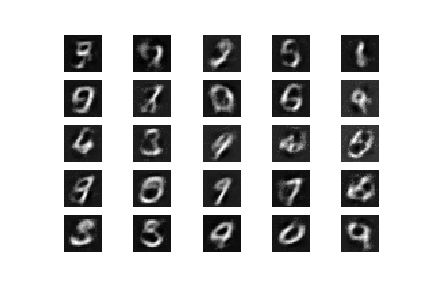

In [50]:
from PIL import Image
Image.open('images/mnist_1800.png')

In [25]:
adversarial_autoencoder.save_weights('gan_mnist_weights.h5')

In [25]:
adversarial_autoencoder.load_weights('gan_mnist_weights.h5')

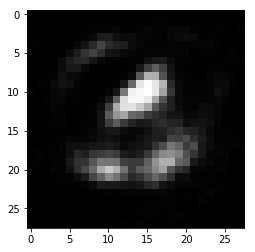

In [26]:
import matplotlib.pyplot as plt
z = np.random.normal(size=(1, latent_dim))
gen_imgs = decoder.predict(z)
gen_imgs = 0.5 * gen_imgs + 0.5
plt.imshow(gen_imgs[0, :, :, 0], cmap='gray')